# NLP Project: Classifying Music Genres Based on Song Lyrics
### Yayi Feng (yf7qq), Hannah Lee, Will Jarrad

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import one_hot , Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import LSTM

In [3]:
os.chdir('/content/drive/MyDrive/NLP_Project')

## 1. Loading Data

In [4]:
artist = pd.read_csv('artists-data.csv')
artist.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


**We extracted the Link and Genres columns. The Link column will be useful for merging with the lyrics dataset.**

In [5]:
link_genre = artist[['Link', 'Genres']]
link_genre.head()

,Link,Genres
0,/ivete-sangalo/,Pop; Axé; Romântico
1,/chiclete-com-banana/,Axé
2,/banda-eva/,Axé; Romântico; Reggae
3,/e-o-tchan/,Axé
4,/claudia-leitte/,Pop; Axé; Romântico


**Check for Duplicates**

In [6]:
link_genre.duplicated(subset = 'Link', keep = 'first').value_counts()

False    4168
dtype: int64

In [7]:
link_genre.Genres.value_counts()

Gospel/Religioso                             244
Sertanejo                                     97
Funk Carioca                                  61
Indie                                         53
Pop                                           49
                                            ... 
Gospel/Religioso; Jovem Guarda                 1
Gospel/Religioso; Instrumental; Pop            1
Gospel/Religioso; Soul Music; Black Music      1
Heavy Metal; Hardcore; Gospel/Religioso        1
World Music; Black Music; Blues                1
Name: Genres, Length: 1750, dtype: int64

###Load Lyrics Dataset

In [8]:
lyric = pd.read_csv('lyrics-data.csv')
lyric.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [9]:
lyric.language.value_counts()

en     191814
pt     157393
es       9917
rw       1679
it       1432
fr       1225
de        844
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         13
ms          8
ja          7
st          7
ht          5
gd          4
ru          4
ar          4
eu          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
vi          1
iw          1
sr          1
hmn         1
hr          1
fa          1
sq          1
zh          1
lv          1
sl          1
Name: language, dtype: int64

In [10]:
eng_lyrics = lyric.drop(lyric[lyric['language'] !='en'].index)
eng_lyrics.head()

,ALink,SName,SLink,Lyric,language
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


In [11]:
eng_lyrics.language.value_counts()

en    191814
Name: language, dtype: int64

**Check for duplicates in SLink (link to songs)**

In [12]:
eng_lyrics.duplicated(subset = 'SLink', keep = 'first').value_counts()

False    191793
True         21
dtype: int64

In [13]:
eng_lyrics.drop_duplicates(subset='SLink', keep='first', inplace=True, ignore_index=False)

In [14]:
eng_lyrics.drop_duplicates(inplace=True)

In [15]:
eng_lyrics.duplicated().value_counts()

False    191793
dtype: int64

In [16]:
lyrics = eng_lyrics[['ALink', 'Lyric']]
lyrics.head()

,ALink,Lyric
69,/ivete-sangalo/,I feel so unsure\nAs I take your hand and lead...
86,/ivete-sangalo/,"Don't let them fool, ya\nOr even try to school..."
88,/ivete-sangalo/,"Baby, let's cruise, away from here\nDon't be c..."
111,/ivete-sangalo/,"Know it sounds funny\nBut, I just can't stand ..."
140,/ivete-sangalo/,You've got that look again\nThe one I hoped I ...


**Merging the two datasets**

In [17]:
data = pd.merge(lyrics, link_genre, how='inner', left_on='ALink', right_on='Link')
data.head()

,ALink,Lyric,Link,Genres
0,/ivete-sangalo/,I feel so unsure\nAs I take your hand and lead...,/ivete-sangalo/,Pop; Axé; Romântico
1,/ivete-sangalo/,"Don't let them fool, ya\nOr even try to school...",/ivete-sangalo/,Pop; Axé; Romântico
2,/ivete-sangalo/,"Baby, let's cruise, away from here\nDon't be c...",/ivete-sangalo/,Pop; Axé; Romântico
3,/ivete-sangalo/,"Know it sounds funny\nBut, I just can't stand ...",/ivete-sangalo/,Pop; Axé; Romântico
4,/ivete-sangalo/,You've got that look again\nThe one I hoped I ...,/ivete-sangalo/,Pop; Axé; Romântico


In [18]:
data = data.drop(['ALink','Link'], axis=1)
data.head()

,Lyric,Genres
0,I feel so unsure\nAs I take your hand and lead...,Pop; Axé; Romântico
1,"Don't let them fool, ya\nOr even try to school...",Pop; Axé; Romântico
2,"Baby, let's cruise, away from here\nDon't be c...",Pop; Axé; Romântico
3,"Know it sounds funny\nBut, I just can't stand ...",Pop; Axé; Romântico
4,You've got that look again\nThe one I hoped I ...,Pop; Axé; Romântico


In [19]:
data.Genres.value_counts()

Country                                  4774
Rock                                     4671
Heavy Metal                              4394
Indie                                    4289
Rap; Hip Hop                             3425
                                         ... 
J-Pop/J-Rock; Rock; Trilha Sonora           1
Surf Music; Reggae; Romântico               1
Pop/Rock; Dance; Romântico                  1
J-Pop/J-Rock; Trilha Sonora; Pop/Rock       1
Reggaeton; Reggae; Axé                      1
Name: Genres, Length: 1190, dtype: int64

**Filter genres that have less than 3000 songs to avoid class imbalance**

In [20]:
filter_df = data.groupby("Genres").filter(lambda x: len(x) > 3000)

In [21]:
filter_df.Genres.value_counts()

Country         4774
Rock            4671
Heavy Metal     4394
Indie           4289
Rap; Hip Hop    3425
Name: Genres, dtype: int64

*Get* list of genres

In [22]:
genres = (pd.Series([x.split('; ') for x in filter_df.Genres.value_counts().keys()]).explode().values)
# filter_df.Genres.value_counts().keys()
import numpy as np
genres = np.unique(genres)
genres = np.unique(pd.Series([x.split('/') for x in genres]).explode().values).tolist()
genres = genres+['Hip Hop']
genres

['Country', 'Heavy Metal', 'Hip Hop', 'Indie', 'Rap', 'Rock', 'Hip Hop']

In [23]:
filter_df.Genres = [x.replace('/','; ') for x in filter_df.Genres]

Make encoded table

In [24]:
dummy = filter_df.Genres.str.get_dummies('; ')

In [25]:
df = pd.DataFrame(filter_df.Lyric).join(dummy)

**Clean lyrics**

In [26]:
filter_df.Lyric=[x.replace('\n',' ').replace('\'','') for x in df.Lyric]

In [27]:
import re 
sub = [re.sub("[\(\[].*?[\)\]]", "", x) for x in filter_df.Lyric]

sub = [re.sub('{.*?}', '', x) for x in sub]
sub[0:10]

['Two young people without a thing Say some vows and spread their wings Settle down with just what they need Livin on love  She dont care bout whats in style She just likes the way he smiles It takes more than marble and tile Livin on love  Livin on love, buyin on time Without somebody nothing aint worth a dime Just like an old fashion story book rhyme Livin on love It sounds simple, thats what youre thinkin But love can walk through fire without blinkin It doenst take much when you get enough Livin on love  Two old people without a thing Children gone but still they sing Side by side in that front porch swing Livin on love  He cant see anymore She can barely sweep the floor Hand in hand theyll walk through that door Just livin on love  Livin on love, buyin on time Without somebody nothing aint worth a dime Just like an old fashion story book rhyme Livin on love It sounds simple thats what youre thinkin But love can walk through fire without blinkin It doenst take much when you get eno

In [28]:
from keras.preprocessing.text import one_hot , Tokenizer

In [29]:
filter_df.head()

,Lyric,Genres
21227,Two young people without a thing Say some vows...,Country
21228,"Here we are, talkin bout forever Both know dam...",Country
21229,When I look into your soft green eyes And when...,Country
21230,Way down yonder on the Chattahoochee It gets h...,Country
21231,Have a little love on a little honeymoon You g...,Country


##2. Data Visualization

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

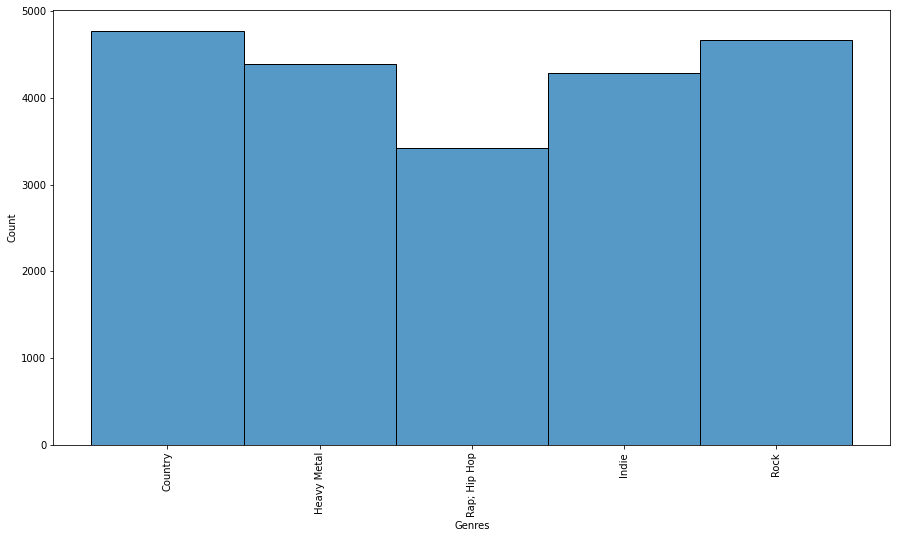

In [31]:
plt.figure(figsize = (15,8))
g = sns.histplot(data=filter_df, x="Genres")
plt.xticks(rotation=90)

## Model Building

In [32]:
y_labels = filter_df.drop('Lyric', axis = 1)
y_labels.value_counts()

Genres      
Country         4774
Rock            4671
Heavy Metal     4394
Indie           4289
Rap; Hip Hop    3425
dtype: int64

In [33]:
genres = y_labels.Genres.unique()
genre_map = dict(enumerate(genres))

In [34]:
genre_map = {value:key for key, value in genre_map.items()}

In [35]:
y_labels.Genres = y_labels.Genres.map(genre_map)

In [36]:
y_labels

,Genres
21227,0
21228,0
21229,0
21230,0
21231,0
...,...
181843,4
181844,4
181845,4
181846,4


In [37]:
y_labels.value_counts()

Genres
0         4774
4         4671
1         4394
3         4289
2         3425
dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sub, y_labels, test_size=0.4, random_state=42)

In [39]:
sub[0]

'Two young people without a thing Say some vows and spread their wings Settle down with just what they need Livin on love  She dont care bout whats in style She just likes the way he smiles It takes more than marble and tile Livin on love  Livin on love, buyin on time Without somebody nothing aint worth a dime Just like an old fashion story book rhyme Livin on love It sounds simple, thats what youre thinkin But love can walk through fire without blinkin It doenst take much when you get enough Livin on love  Two old people without a thing Children gone but still they sing Side by side in that front porch swing Livin on love  He cant see anymore She can barely sweep the floor Hand in hand theyll walk through that door Just livin on love  Livin on love, buyin on time Without somebody nothing aint worth a dime Just like an old fashion story book rhyme Livin on love It sounds simple thats what youre thinkin But love can walk through fire without blinkin It doenst take much when you get enou

In [40]:
y_train.dtypes

Genres    int64
dtype: object

## Naive Bayes

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# fit pipeline to train data
model_0.fit(
    X=X_train,
    y=y_train
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [42]:
model_0.score(
    X=X_test,
    y=y_test
)

0.5906982138714916

In [43]:
baseline_preds = model_0.predict(X_test)
baseline_preds

array([1, 0, 0, ..., 0, 0, 1])

In [44]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [45]:


baseline_results = calculate_results(
    y_true=y_test,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 0.5906982138714916,
 'f1': 0.5533098011590563,
 'precision': 0.6689937817038,
 'recall': 0.5906982138714916}

## CNN

In [46]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import one_hot , Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [47]:
import numpy as np
def load_glove():
    embeddings_index = dict()
    f = open('/content/drive/MyDrive/glove.6B.100d.txt') # replace this with the path to your downloaded txt file
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    # create a weight matrix for words in training docs
    
    return embeddings_index

In [48]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

tk = Tokenizer()
tk.fit_on_texts(X_train)
embeddings_index = load_glove()
vocab_size = len(tk.word_index) + 1
encoded_docs = tk.texts_to_sequences(X_train)
max_length = max([len(encoded) for encoded in encoded_docs])
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
encoded_test_docs = tk.texts_to_sequences(X_test)
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

n_classes = 5
EMBEDDING_DIM = 100
word_index=tk.word_index
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))


Loaded 400001 word vectors.


In [49]:
embedding_matrix.shape

(47870, 100)

In [50]:
from keras import Input
from keras.layers import Dropout, Dense,Input,Embedding,Flatten, MaxPooling1D, Conv1D, GlobalMaxPool1D
from keras.models import Sequential,Model
from keras.initializers import Constant
import math
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        if len(embedding_matrix[i]) !=len(embedding_vector):
            print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                "into shape",str(len(embedding_vector))," Please make sure your"
                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
            exit(1)

        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
sequence_input = Input(shape=(max_length,), dtype='int32')
x = embedding_layer(sequence_input)
x = Dropout(0.3)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.15)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128,5, activation='relu')(x)
x = GlobalMaxPool1D()(x) 
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(n_classes, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
def scheduler(epoch, lr):
   if epoch < 6:
    return lr
   else:
    return lr * math.exp(-0.1)
schedule = LearningRateScheduler(scheduler)
history = model.fit(padded_docs, y_train, validation_data=(padded_test_docs, y_test),epochs=12, batch_size=32 ,verbose=1,callbacks=[schedule])


Epoch 1/12
405/405 [==============================] - 23s 29ms/step - loss: 1.2971 - acc: 0.4197 - val_loss: 1.1353 - val_acc: 0.4973 - lr: 0.0010
Epoch 2/12
405/405 [==============================] - 11s 27ms/step - loss: 1.0719 - acc: 0.5222 - val_loss: 1.0411 - val_acc: 0.5543 - lr: 0.0010
Epoch 3/12
405/405 [==============================] - 11s 27ms/step - loss: 1.0138 - acc: 0.5514 - val_loss: 0.9839 - val_acc: 0.5659 - lr: 0.0010
Epoch 4/12
405/405 [==============================] - 12s 29ms/step - loss: 0.9732 - acc: 0.5788 - val_loss: 1.0140 - val_acc: 0.5736 - lr: 0.0010
Epoch 5/12
405/405 [==============================] - 11s 28ms/step - loss: 0.9282 - acc: 0.5992 - val_loss: 0.9149 - val_acc: 0.6097 - lr: 0.0010
Epoch 6/12
405/405 [==============================] - 11s 28ms/step - loss: 0.8828 - acc: 0.6269 - val_loss: 0.9008 - val_acc: 0.6199 - lr: 0.0010
Epoch 7/12
405/405 [==============================] - 11s 28ms/step - loss: 0.8538 - acc: 0.6400 - val_loss: 0.8772 - 

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3140)]            0         
                                                                 
 embedding (Embedding)       (None, 3140, 100)         4787000   
                                                                 
 dropout (Dropout)           (None, 3140, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, 3136, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 627, 128)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 627, 128)          0         
                                                             

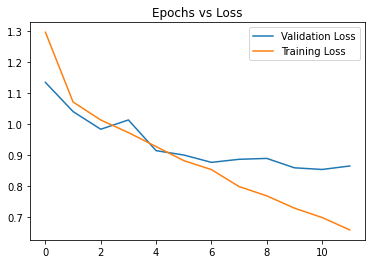

In [52]:
values = history.history
val_loss = values['val_loss']
training_loss = values['loss']
training_acc = values['acc']
validation_acc = values['val_acc']

plt.plot(val_loss,label = 'Validation Loss')
plt.plot(training_loss,label = 'Training Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

In [204]:
y_hat = model.predict(padded_test_docs)
y_hat=np.argmax(y_hat,axis=1)

y_hat=pd.DataFrame(y_hat,index=y_test.index)
foo = pd.DataFrame(y_hat[0]).join(y_test.Genres)
mismatches =foo.loc[~(foo[0]==foo.Genres)]
mismatches = mismatches.rename(columns={0:'preds'})
country_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==0].index[0]
rock_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==1].index[0]
heavy_metal_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==2].index[0]
indie_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==3].index[0]
rap_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==4].index[0]
str(filter_df.loc[[country_misclass_ex]].Lyric)
pd.options.display.max_colwidth = 5000
print(filter_df.loc[[country_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[country_misclass_ex]].values[0][0])
print(filter_df.loc[[rock_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rock_misclass_ex]].values[0][0])
print(filter_df.loc[[heavy_metal_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[heavy_metal_misclass_ex]].values[0][0])
print(filter_df.loc[[indie_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[indie_misclass_ex]].values[0][0])
print(filter_df.loc[[rap_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rap_misclass_ex]].values[0][0])

25822    I see them rise From beneath the ground Life was lost but now its found The ghosts want somethin To take their turn To dance around the stone Work the fingers to the bone Hold on to nothin  Day for the dead To dance among the living Day for the dead To dance among the living  We find forgiveness For the wrong weve done Watch the dyin of the day Another settin sun We find redemption In the love weve won Just a little company Until our work is done  Day for the dead To dance among the living Day for the dead To dance among the living  Who says you cant go back? Who says you cant go back Back to where you started from? (are you ready?) Who says you cant go back? (are you ready?) Who says you cant go back Back to where you started from? (are you ready) Who says you cant go back? (are you ready?)  The bone falls on the river Styx The man who makes you dead Coins lay on his eyes Just to pay your fare  Day for the dead To dance among the living  Day for the dead To dance among the li

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print('accuracy: ',accuracy_score(y_hat,y_test),'\n',
'precision:',precision_score(y_hat,y_test,average=None),'\n',
'f1 score (per class): ',f1_score(y_hat,y_test,average=None),'\n',
'macro f1 score:',f1_score(y_hat,y_test,average='macro'))

accuracy:  0.6464857341684064 
 precision: [0.80359979 0.70874862 0.92557803 0.54614486 0.3058438 ] 
 f1 score (per class):  [0.64650767 0.76738609 0.92658228 0.55113469 0.36673215] 
 macro f1 score: 0.65166857586481


## RNN

In [41]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [42]:
tk = Tokenizer()
tk.fit_on_texts(X_train)

vocab_size = len(tk.word_index) + 1
encoded_docs = tk.texts_to_sequences(X_train)
max_length = max([len(encoded) for encoded in encoded_docs])
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
encoded_test_docs = tk.texts_to_sequences(X_test)
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

n_classes = 5
EMBEDDING_DIM = 100
word_index=tk.word_index

In [43]:
embedding_vector = {}
f = open('/content/drive/MyDrive/glove.6B.100d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(tk.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400001it [00:07, 53460.11it/s]
100%|██████████| 47869/47869 [00:00<00:00, 596739.37it/s]


In [44]:
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional, SpatialDropout1D

In [45]:
rnnmodel = Sequential()
rnnmodel.add(Embedding(vocab_size,EMBEDDING_DIM,weights = [embedding_matrix],input_length=max_length,trainable = False))
rnnmodel.add(Bidirectional(CuDNNLSTM(75)))
rnnmodel.add(Dense(32,activation = 'relu'))
rnnmodel.add(Dense(n_classes, activation='softmax'))

rnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3140, 100)         4787000   
                                                                 
 bidirectional (Bidirectiona  (None, 150)              106200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4832      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4,898,197
Trainable params: 111,197
Non-trainable params: 4,787,000
_________________________________________________________________


Attempted to run a vanilla LSTM model but it takes about 31 minutes to run an epoch

In [46]:
rnnmodel.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [47]:

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop_cb = EarlyStopping(patience=3, restore_best_weights= True)


history2 = rnnmodel.fit(padded_docs, y_train, validation_data=(padded_test_docs, y_test), 
                     callbacks= [model_checkpoint_callback, early_stop_cb], batch_size = 64, epochs=8, verbose=1)

Epoch 1/8
203/203 [==============================] - 60s 276ms/step - loss: 1.4507 - acc: 0.3553 - val_loss: 1.4676 - val_acc: 0.3360
Epoch 2/8
203/203 [==============================] - 53s 262ms/step - loss: 1.3348 - acc: 0.4171 - val_loss: 1.1112 - val_acc: 0.5273
Epoch 3/8
203/203 [==============================] - 53s 260ms/step - loss: 1.0800 - acc: 0.5250 - val_loss: 1.0104 - val_acc: 0.5663
Epoch 4/8
203/203 [==============================] - 53s 262ms/step - loss: 0.9927 - acc: 0.5674 - val_loss: 1.0093 - val_acc: 0.5634
Epoch 5/8
203/203 [==============================] - 53s 262ms/step - loss: 0.9541 - acc: 0.5908 - val_loss: 1.0250 - val_acc: 0.5760
Epoch 6/8
203/203 [==============================] - 62s 304ms/step - loss: 0.9189 - acc: 0.6124 - val_loss: 0.9097 - val_acc: 0.6272
Epoch 7/8
203/203 [==============================] - 62s 305ms/step - loss: 0.8699 - acc: 0.6378 - val_loss: 0.8988 - val_acc: 0.6299
Epoch 8/8
203/203 [==============================] - 53s 259ms

In [48]:
y_hat = rnnmodel.predict(padded_test_docs)
y_hat=np.argmax(y_hat,axis=1)



In [49]:
y_hat=pd.DataFrame(y_hat,index=y_test.index)
foo = pd.DataFrame(y_hat[0]).join(y_test.Genres)
mismatches =foo.loc[~(foo[0]==foo.Genres)]
mismatches = mismatches.rename(columns={0:'preds'})
country_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==0].index[0]
rock_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==1].index[0]
heavy_metal_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==2].index[0]
indie_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==3].index[0]
rap_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==4].index[0]
str(filter_df.loc[[country_misclass_ex]].Lyric)
pd.options.display.max_colwidth = 5000
print(filter_df.loc[[country_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[country_misclass_ex]].values[0][0])
print(filter_df.loc[[rock_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rock_misclass_ex]].values[0][0])
print(filter_df.loc[[heavy_metal_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[heavy_metal_misclass_ex]].values[0][0])
print(filter_df.loc[[indie_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[indie_misclass_ex]].values[0][0])
print(filter_df.loc[[rap_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rap_misclass_ex]].values[0][0])

21891    Oh, you drive me crazy. I cant stop the way I feel. Things you do dont seem real. Tell you what I got in mind cause were runnin out of time. Just turn loose and let it be, this waitin round is killin me. You drive me crazy like no one else. You drive me crazy and I cant help myself. I cant get any rest. People say that Im obsessed. Youre everything I want in life, but to me thats no surprise. And what I have Ill give to you. I hope you feel the same way, too. Cause you drive me crazy Like no one else. You drive me crazy and I cant help myself. I wont make it on my own. No one likes to be alone. You drive me crazy, yes its true. Id give it all up just to be with you. Cause you drive me crazy like no one else. Oh, you drive me crazy and I cant help myself, I cant help myself. Oh, you drive me crazy like no one else. You drive me crazy and I cant help myself. Oh, you drive me crazy like no one else. Oh, you drive me crazy and I cant help myself. Oh, you drive me crazy like nobody

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print('accuracy: ',accuracy_score(y_hat,y_test),'\n',
'precision:',precision_score(y_hat,y_test,average=None),'\n',
'f1 score (per class): ',f1_score(y_hat,y_test,average=None),'\n',
'macro f1 score:',f1_score(y_hat,y_test,average='macro'))

accuracy:  0.6416144745998609 
 precision: [0.66543145 0.68715393 0.88511561 0.56834112 0.4565811 ] 
 f1 score (per class):  [0.64461538 0.75740006 0.91829085 0.5563179  0.42860805] 
 macro f1 score: 0.6610464490756434


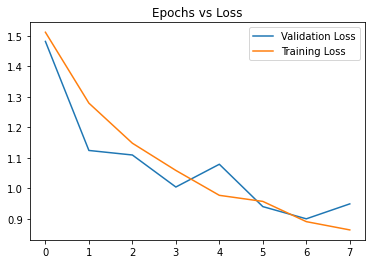

In [215]:
values = history2.history
val_loss = values['val_loss']
training_loss = values['loss']
training_acc = values['acc']
validation_acc = values['val_acc']
epochs = range(8)

plt.plot(epochs,val_loss,label = 'Validation Loss')
plt.plot(epochs,training_loss,label = 'Training Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

## Transformer

In [51]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import one_hot , Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [52]:
tk = Tokenizer()
tk.fit_on_texts(X_train)
vocab_size = len(tk.word_index) + 1

# integer encode the documents
encoded_docs = tk.texts_to_sequences(X_train)
encoded_test_docs = tk.texts_to_sequences(X_test)
print(encoded_docs[1])

[26, 72, 9, 118, 1, 187, 888, 11, 8, 113, 175, 3, 692, 10, 16, 650, 29, 72, 9, 118, 1, 187, 888, 11, 8, 113, 175, 3, 692, 10, 16, 650, 3, 1889, 1, 797, 2, 368, 13, 14, 140, 18, 169, 24, 3, 67, 5, 27636, 124, 11, 1, 3175, 3, 123, 63, 10237, 39, 67, 5, 506, 54, 32, 16, 2, 73, 18, 6, 173, 3, 508, 92, 465, 30, 62, 1, 1414, 984, 2, 259, 876, 20, 7, 1303, 3, 1215, 323, 3, 1215, 323, 211, 298, 6, 3, 26, 72, 9, 118, 1, 187, 888, 11, 8, 113, 175, 3, 692, 10, 16, 650, 29, 72, 9, 118, 1, 187, 888, 11, 8, 113, 175, 3, 692, 10, 16, 650, 3, 448, 14, 512, 274, 71, 2, 299, 6, 33, 10, 39, 2, 150, 5827, 1, 5980, 11, 91, 13, 2, 259, 19, 105, 1526, 4, 2, 93, 20, 1267, 23, 95, 197, 20, 974, 17, 157, 95, 3, 508, 92, 7291, 1, 470, 13, 19, 299, 6, 69, 37, 6, 3, 1215, 323, 3, 1215, 323, 211, 298, 6, 3, 26, 72, 9, 118, 1, 187, 888, 11, 8, 113, 175, 3, 692, 10, 16, 650, 29, 72, 9, 118, 1, 187, 888, 11, 8, 113, 175, 3, 692, 10, 16, 650, 3, 1215, 323, 3, 1215, 323, 211, 298, 6, 3, 3, 1215, 323, 3, 1215, 323, 211, 

In [53]:
max_len = max([len(encoded) for encoded in encoded_docs])

print(max_len)

3140


In [54]:
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_len, padding='post')

In [55]:
from keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [56]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [57]:
import tensorflow as tf
from keras import Model

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

transformer = Model(inputs=inputs, outputs=outputs)
transformer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3140)]            0         
                                                                 
 token_and_position_embeddin  (None, 3140, 32)         1632320   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 3140, 32)         10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [58]:
from keras.callbacks import ReduceLROnPlateau

transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop_cb = EarlyStopping(patience=3, restore_best_weights= True)

transformer_history = transformer.fit(
    padded_docs, y_train, batch_size=25, 
    epochs=4, 
    validation_data=(padded_test_docs, y_test),
    callbacks= [early_stop_cb, model_checkpoint_callback]
)

Epoch 1/4
518/518 [==============================] - 173s 330ms/step - loss: 1.3338 - accuracy: 0.3696 - val_loss: 1.2188 - val_accuracy: 0.4419
Epoch 2/4
518/518 [==============================] - 184s 355ms/step - loss: 1.0073 - accuracy: 0.5550 - val_loss: 0.8967 - val_accuracy: 0.6139
Epoch 3/4
518/518 [==============================] - 187s 362ms/step - loss: 0.8196 - accuracy: 0.6465 - val_loss: 0.9382 - val_accuracy: 0.5982
Epoch 4/4
518/518 [==============================] - 187s 361ms/step - loss: 0.7068 - accuracy: 0.7046 - val_loss: 0.8984 - val_accuracy: 0.6196


In [ ]:
values = transformer_history.history
val_loss = values['val_loss']
training_loss = values['loss']
training_acc = values['accuracy']
validation_acc = values['val_accuracy']

plt.plot(val_loss,label = 'Validation Loss')
plt.plot(training_loss,label = 'Training Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

In [59]:
y_hat = transformer.predict(padded_test_docs)
y_hat=np.argmax(y_hat,axis=1)

In [60]:
y_hat=pd.DataFrame(y_hat,index=y_test.index)
foo = pd.DataFrame(y_hat[0]).join(y_test.Genres)
mismatches =foo.loc[~(foo[0]==foo.Genres)]
mismatches = mismatches.rename(columns={0:'preds'})
country_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==0].index[0]
rock_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==1].index[0]
heavy_metal_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==2].index[0]
indie_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==3].index[0]
rap_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==4].index[0]
str(filter_df.loc[[country_misclass_ex]].Lyric)
pd.options.display.max_colwidth = 5000
print(filter_df.loc[[country_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[country_misclass_ex]].values[0][0])
print(filter_df.loc[[rock_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rock_misclass_ex]].values[0][0])
print(filter_df.loc[[heavy_metal_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[heavy_metal_misclass_ex]].values[0][0])
print(filter_df.loc[[indie_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[indie_misclass_ex]].values[0][0])
print(filter_df.loc[[rap_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rap_misclass_ex]].values[0][0])

26789    The end has come and found us here With our toys scattered all around us here The puzzle that we never found an answer for Still asks us, darlin, just what all the games were for And here we stand in a box of sand Wheres the playground Susie? Youre the one whos supposed to know her way around Wheres the playground Susie If I dont stay around? If I dont stay around?   The carousel has stopped us here It twirled a time or two and then it dropped us here And still youre not content with something about me But what merry-go-round can you ride without me To take your hand ? How would you stand?  Wheres the playground Susie If I decide to let you go and play around? Wheres the playground Susie If I dont stay around? If I dont stay around?  Wheres the playground Susie? Youre the one whos supposed to know her way around Wheres the playground Susie If I decide to let you go and play around
Name: Lyric, dtype: object 
 predicted:  3
84453    Now you all know The bards sang their songs W

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print('accuracy: ',accuracy_score(y_hat,y_test),'\n',
'precision:',precision_score(y_hat,y_test,average=None),'\n',
'f1 score (per class): ',f1_score(y_hat,y_test,average=None),'\n',
'macro f1 score:',f1_score(y_hat,y_test,average='macro'))

## Transformer BERT

In [ ]:
filter_df.head()

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(filter_df['Lyric'], filter_df['Genres'], test_size=0.3, random_state=42)

In [63]:
train_sentences = X_train.tolist()
val_sentences = X_test.tolist()

In [64]:
train_sentences[:10]

['I grew up in small town Wheat fiels Foreign Downtown kinda place There really wasnt much around You blink and you miss it  I never knew what life could bring But I always had big dreams I loved to play my guitar and sing And every night Id wish that Id get a shot on the Opry stage and have people come and see me play Blastin on the radio waves, enough to make my mama cry  Cause thats where I come from Thats who I am Hard Workin and God Blessed Yes Sir and Thank you maam The best things around that I have ever seen came from small towns and big dreams  Small town went and grew up but I never changed much by Gods grace Friends and family kept in touch when I moved to Tennesse Sing my songs and travel round I met a girl and were settlin down Wanna find a small town where we can raise a family  Cause thats where I come from Thats who I am Hard workin and God blessed Yes sir and thank you maam The best things around that I have ever seen Came from small towns and big dreams  Been around t

In [65]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(y_test.to_numpy().reshape(-1, 1))

train_labels_one_hot.shape

(15087, 5)

In [66]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
val_labels_encoded = label_encoder.fit_transform(y_test.to_numpy())

In [67]:
# turn our data into tensorflow datasets
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [68]:
# take the tensorslicedatasets and turn them into perfected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [236]:
! pip install tensorflow_text
! pip install tensorflow_hub

     |████████████████████████████████| 4.9 MB 35.6 MB/s 
     |████████████████████████████████| 462 kB 60.5 MB/s 


In [69]:
# bert preprocessing + bert embedding
import tensorflow_hub as hub
import tensorflow_text as text
tf_hub_bert_preprocessing_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    name='BERT-preprocessing'
    )

In [70]:
import random
target_sentence = [random.choice(train_sentences)]
text_preprocessed = tf_hub_bert_preprocessing_layer(target_sentence)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 10113  2180  2102  2017  2022  2026 10113  1998  1999 14127 18796]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [71]:
tf_hub_bert_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    trainable=True,
    name='BERT-embedding'
    )

In [ ]:
from tensorflow.keras import layers

In [72]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='None')
bert_preprocessed_inputs = tf_hub_bert_preprocessing_layer(token_inputs)
bert_embeddings = tf_hub_bert_embedding_layer(bert_preprocessed_inputs)
x = bert_embeddings['pooled_output']
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(x)
bert_model = tf.keras.Model(token_inputs, output_layer)

In [73]:
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 None (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 BERT-preprocessing (KerasLayer  {'input_mask': (Non  0          ['None[0][0]']                   
 )                              e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [74]:
from tensorflow.keras.optimizers import Adam

# compile model with label smoothing to fight against overfitting
bert_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=Adam(learning_rate=2e-5),
    metrics=['accuracy']
)

In [75]:
#from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop_cb = EarlyStopping(patience=2, restore_best_weights= True)


history_bert = bert_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks= [early_stop_cb, model_checkpoint_callback]

)

Epoch 1/20
472/472 [==============================] - 135s 275ms/step - loss: 1.3155 - accuracy: 0.5568 - val_loss: 1.1357 - val_accuracy: 0.6802
Epoch 2/20
472/472 [==============================] - 128s 272ms/step - loss: 1.1480 - accuracy: 0.6789 - val_loss: 1.0882 - val_accuracy: 0.7148
Epoch 3/20
472/472 [==============================] - 128s 272ms/step - loss: 1.0679 - accuracy: 0.7420 - val_loss: 1.0634 - val_accuracy: 0.7343
Epoch 4/20
472/472 [==============================] - 128s 272ms/step - loss: 1.0043 - accuracy: 0.7868 - val_loss: 1.0760 - val_accuracy: 0.7403
Epoch 5/20
472/472 [==============================] - 126s 268ms/step - loss: 0.9457 - accuracy: 0.8352 - val_loss: 1.0850 - val_accuracy: 0.7403


In [ ]:
values = history_bert.history
val_loss = values['val_loss']
training_loss = values['loss']
training_acc = values['accuracy']
validation_acc = values['val_accuracy']

plt.plot(val_loss,label = 'Validation Loss')
plt.plot(training_loss,label = 'Training Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

In [76]:
bert_pred_probs = bert_model.predict(val_dataset, verbose=1)
bert_preds = tf.argmax(bert_pred_probs, axis=1)
bert_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=bert_preds)
bert_results

203/203 [==============================] - 30s 143ms/step


NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print('accuracy: ',accuracy_score(bert_preds,val_labels_encoded),'\n',
'precision:',precision_score(bert_preds,val_labels_encoded,average=None),'\n',
'f1 score (per class): ',f1_score(bert_preds,val_labels_encoded,average=None),'\n',
'macro f1 score:',f1_score(bert_preds,val_labels_encoded,average='macro'))

In [97]:
y_test[[115650]]

115650    Indie
Name: Genres, dtype: object

In [101]:
y_test = y_test.replace({'Heavy Metal':2,'Indie':3,'Country':0,'Rock':1,'Rap; Hip Hop':4})

In [103]:
bert_preds=pd.DataFrame(y_hat,index=y_test.index)
foo = pd.DataFrame(bert_preds[0]).join(y_test)
mismatches =foo.loc[~(foo[0]==foo.Genres)]
mismatches = mismatches.rename(columns={0:'preds'})
country_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==0].index[0]
rock_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==1].index[0]
heavy_metal_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==2].index[0]
indie_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==3].index[0]
rap_misclass_ex = mismatches.sort_values('Genres').loc[mismatches.Genres==4].index[0]
str(filter_df.loc[[country_misclass_ex]].Lyric)
pd.options.display.max_colwidth = 5000
print(filter_df.loc[[country_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[country_misclass_ex]].values[0][0])
print(filter_df.loc[[rock_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rock_misclass_ex]].values[0][0])
print(filter_df.loc[[heavy_metal_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[heavy_metal_misclass_ex]].values[0][0])
print(filter_df.loc[[indie_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[indie_misclass_ex]].values[0][0])
print(filter_df.loc[[rap_misclass_ex]].Lyric,'\n','predicted: ',y_hat.loc[[rap_misclass_ex]].values[0][0])

28950    Why so lonely why is my world in such a spin Now hes gone and yet I guess I still love him Why so lonely why all this misery I knew it couldnt last he never belong to me  If Id been smart I would have never taken that second chance He hurt me once before and now hes done it again Why so lonely... Why so lonely why so lonely
Name: Lyric, dtype: object 
 predicted:  3
180004    A simple life, I will not have It doesnt satisfy me I dont believe in the status quo It kinda leaves me weak  A mountain high is what I climb Ill swim a river deep So if you crave the time of your life Try to keep up with me, hey  Im gonna live Im gonna fly Im gonna soar till the day I die And all the wings of a bird are prey  Hey hey hey Your absolutely what I crave Look at me I got a smile on my face  You know it dont come cheap Sure I live the American dream Go ahead and crucify me, yeah  Im gonna live Im gonna fly Im gonna soar till the day I die And all the wings of a bird are prey  Hey hey hey Your 